In [5]:
import torch

def uniformity(x, t=2):
    return torch.pdist(x, p=2).pow(2).mul(-t).exp().mean().log()

def tolerance(x, l):
    total_distances = 0.0
    for i in range(int(l.min()), int(l.max()) + 1):
        cur_features = x[(l == i).nonzero(as_tuple=True)[0]]
        distances = torch.mm(cur_features, cur_features.T)
        mask = torch.ones((cur_features.shape[0], cur_features.shape[0])) - torch.eye(cur_features.shape[0])
        masked_distances = distances * mask
        total_distances += masked_distances.mean()
    return total_distances.mean() / (1 + l.max() - l.min())

datasets = ['aircraft', 'cars', 'cub', 'dogs', 'flowers', 'nabirds', 'imagenet']
backbones = ['btwins_r50_1000', 'dcv2_r50_800', 'moco_r50_800', 'simclr_r50_200', 'simsiam_r50_100', 'supervised_r50', 'swav_r50_800']

results = {}
for dataset in datasets:
    if dataset not in results:
        results[dataset] = {}
    print(f'Dataset: {dataset}')
    for backbone in backbones:
        if backbone not in results[dataset]:
            results[dataset][backbone] = {}
        print(f'Backbone: {backbone}')
        features_path = '/vulcanscratch/mgwillia/vissl/features/' + '_'.join([backbone, dataset, 'features']) + '.pth.tar'
        features = torch.load(features_path)
        targets_path = '/vulcanscratch/mgwillia/vissl/features/' + '_'.join([backbone, dataset, 'targets']) + '.pth.tar'
        targets = torch.load(targets_path)

        #val_features = features['val_features']
        val_features = torch.nn.functional.normalize(features['val_features'], p=2, dim=1)
        val_targets = targets['val_targets']
        unif = uniformity(val_features, t=2) * -1
        tol = tolerance(val_features, val_targets)
        results[dataset][backbone]['uniformity'] = unif.item()
        results[dataset][backbone]['tolerance'] = tol.item()
        print(unif)
        print(tol)
    print('')

Dataset: aircraft
Backbone: btwins_r50_1000
tensor(1.3352)
tensor(0.6672)
Backbone: dcv2_r50_800
tensor(0.8625)
tensor(0.7771)
Backbone: moco_r50_800
tensor(0.6940)
tensor(0.7946)
Backbone: simclr_r50_200
tensor(1.0004)
tensor(0.7288)
Backbone: simsiam_r50_100
tensor(0.8974)
tensor(0.7650)
Backbone: supervised_r50
tensor(0.6192)
tensor(0.8445)
Backbone: swav_r50_800
tensor(1.0141)
tensor(0.7362)

Dataset: cars
Backbone: btwins_r50_1000
tensor(1.7730)
tensor(0.5847)
Backbone: dcv2_r50_800
tensor(0.9519)
tensor(0.7678)
Backbone: moco_r50_800
tensor(1.2065)
tensor(0.7070)
Backbone: simclr_r50_200
tensor(1.5348)
tensor(0.6305)
Backbone: simsiam_r50_100
tensor(1.1212)
tensor(0.7221)
Backbone: supervised_r50
tensor(0.8424)
tensor(0.8165)
Backbone: swav_r50_800
tensor(1.1037)
tensor(0.7314)

Dataset: cub
Backbone: btwins_r50_1000
tensor(2.2283)
tensor(0.5256)
Backbone: dcv2_r50_800
tensor(1.1559)
tensor(0.7356)
Backbone: moco_r50_800
tensor(1.6999)
tensor(0.6493)
Backbone: simclr_r50_200
tens

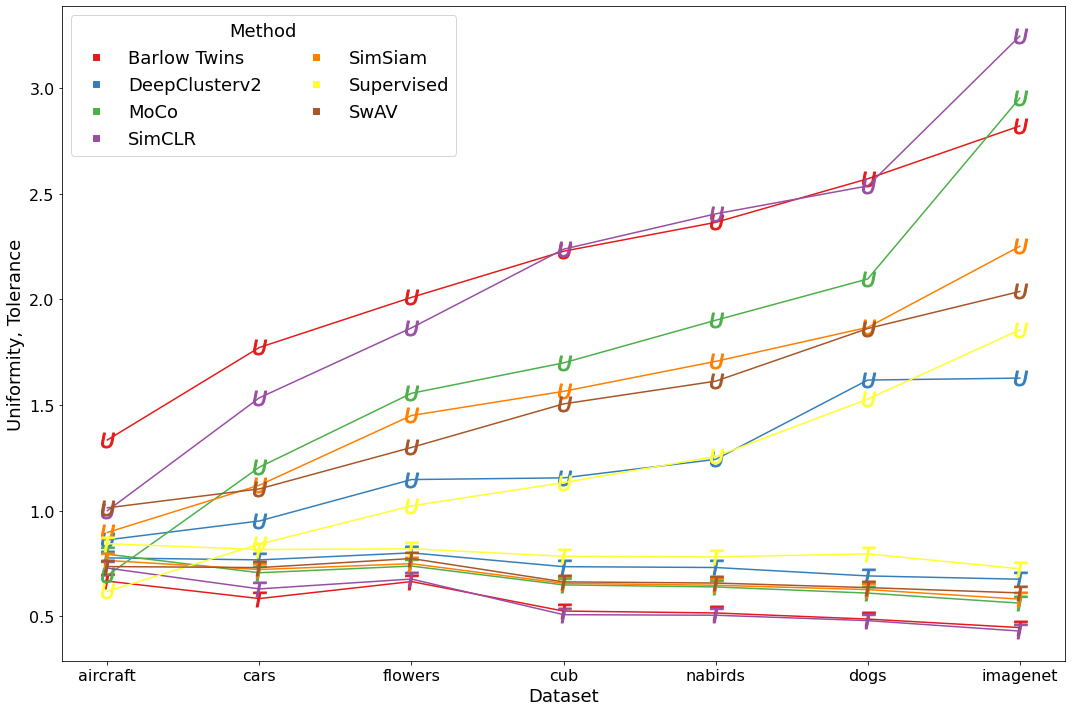

In [21]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (15,10)
cmap = plt.get_cmap('Set1')
colormap = np.array(list(cmap.colors))

datasets = ['aircraft', 'cars', 'flowers', 'cub', 'nabirds', 'dogs', 'imagenet']
method_names = ['Barlow Twins', 'DeepClusterv2', 'MoCo', 'SimCLR', 'SimSiam', 'Supervised', 'SwAV']

fig, ax = plt.subplots(1, 1)
for i, backbone in enumerate(backbones):
    uniformities = []
    tolerances = []
    for j, dataset in enumerate(datasets):
        uniformities.append(results[dataset][backbone]['uniformity'])
        tolerances.append(results[dataset][backbone]['tolerance'])
    ax.plot(uniformities, marker="$U$", markersize=15, c=colormap[i], label=backbone)
    ax.plot(tolerances, marker="$T$", markersize=15, c=colormap[i])
    
ax.set_xticks(list(range(0, len(datasets))))
ax.set_xticklabels(datasets)

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colormap[i]) for i in range(7)]
ax.legend(handles,
          method_names,
          title='Method',
          title_fontsize=18,
          scatterpoints=1,
          ncol=2,
          fontsize=18)

ax.set_xlabel('Dataset', fontsize=18)
ax.set_ylabel('Uniformity, Tolerance', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
    
fig.tight_layout()
plt.savefig('uniformity_tolerance_curves', bbox_inches = 'tight',
    pad_inches = 0.1)